In [1]:
import pickle
from datetime import datetime
from dateutil.tz import tzoffset

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import optim
from scipy.stats import kendalltau, spearmanr
from sklearn.preprocessing import OneHotEncoder

# Задача 1

Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый — турниры с dateStart из 2020 года.

In [2]:
with open("players.pkl", "rb") as fio:
    players = pickle.load(fio)

In [3]:
with open("results.pkl", "rb") as fio:
    results = pickle.load(fio)

In [4]:
with open("tournaments.pkl", "rb") as fio:
    tournaments = pickle.load(fio)

In [5]:
dateformat = "%Y-%m-%dT%H:%M:%S%z"

Загрузим данные и разделим на тренировочный и тестовый датасет

In [6]:
train_data =  []
test_data = []

for key, value in results.items():
    for team in value:
        for team_member in team["teamMembers"]:
            tournament_year = datetime.strptime(tournaments[key]["dateStart"], dateformat).year
            if team.get("mask", None) and tournament_year == 2019:
                train_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "questions_mask": team.get("mask", None),
                    "questionQty": tournaments.get(key).get("questionQty"),
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })
            elif team.get("mask", None) and tournament_year == 2020:
                test_data.append({
                    "tournament_id": key,
                    "tournament_name": tournaments.get(key).get("name"),
                    "team_id": team["team"]["id"],
                    "team_name": team["team"]["name"],
                    "position": team.get("position", None),
                    "player_id": team_member["player"]["id"],
                    "player_name": team_member["player"]["surname"] + " " + \
                                   team_member["player"]["name"] + " " + \
                                   team_member["player"]["patronymic"]
                })

In [7]:
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [8]:
del results

оставим только те команды у которых длинна ответов равна количеству вопросов

In [9]:
train_data["questionQty"] = train_data["questionQty"].apply(lambda x: sum(list(x.values())))

In [10]:
train_data[train_data["questions_mask"].apply(len) != train_data["questionQty"]]["tournament_id"].nunique()

12

In [11]:
train_data = train_data[train_data["questions_mask"].apply(len) == train_data["questionQty"]].copy()

посмотрим распределение числа игроков по командам

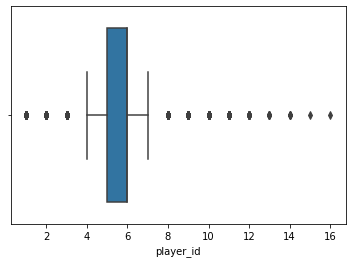

In [12]:
sns.boxplot(x=train_data.groupby(["team_id", "tournament_id"])["player_id"].nunique());

посмотрим на итоговый размер данных и количество турниров

In [13]:
train_data.shape[0], test_data.shape[0]

(414743, 112841)

In [14]:
train_data["tournament_id"].nunique(), test_data["tournament_id"].nunique()

(675, 173)

# Задача 2

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.

- повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Преобразуем тренировочные данные в повопросные результаты по игрокам, в качестве id вопроса будем использовать id турнира и порядковый номер вопроса

In [15]:
question_answer_data = {
    "question": [],
    "player": [],
    "initial_label": [],
    "team_id": [],
    "tournament_id": []
}
for tour_id, team_id, player_id, mask in zip(train_data["tournament_id"], train_data["team_id"], train_data["player_id"], train_data["questions_mask"]):
    for i, result in enumerate(mask):
        if result != "X" and result != "?":
            question_answer_data["tournament_id"].append(tour_id)
            question_answer_data["team_id"].append(team_id)
            question_answer_data["question"].append(f"{tour_id}_{i}")
            question_answer_data["player"].append(player_id)
            question_answer_data["initial_label"].append(int(result))

In [16]:
question_answer_data = pd.DataFrame(question_answer_data)

In [17]:
question_answer_data["player"] = question_answer_data["player"].astype(np.int32)
question_answer_data["team_id"] = question_answer_data["team_id"].astype(np.int32)
question_answer_data["tournament_id"] = question_answer_data["tournament_id"].astype(np.int32)
question_answer_data["question"] = question_answer_data["question"]
question_answer_data["initial_label"] = question_answer_data["initial_label"].astype(np.uint8)

закодируем id игроков и вопросов в OHE представление

In [18]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(question_answer_data[["player", "question"]])

Введем вспомогательные функции для нашей логистической регрессии

- sigmoid - сигмойда над линейной комбинацией признаков и весов
- cost_function - среднее логарифмическое правдоподобие
- gradient - градиент dL/dw на текущей итерации
- fit функция тренировки модели

In [19]:
class LogisticRegression(nn.Module):
    
    def __init__(self, n_features):
        
        super().__init__()
        self.fc = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        return self.sigmoid(self.fc(x))

In [20]:
def m_step(model, x, y, lr=1e-4, n_iter=50):
    
    model.fc.reset_parameters()
    criteria = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr)
    for i in range(n_iter):

        optimizer.zero_grad()
        output = model(x)
        loss = criteria(output, y)
        loss.backward()
        optimizer.step()

введем функцию которая будет брать топ 20 игроков по силе игрока полученной из модели

In [21]:
def get_top_players(parameters, n=20):
    player_weights = {}
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
    top_players = sorted([(k, v) for k, v in player_weights.items()], reverse=True, key=lambda x: x[1])[:n]
    top_players = [
        players[i]["surname"] + " " + 
        players[i]["name"] + " " + 
        players[i]["patronymic"] + " " + str(i) 
        for i, _ in top_players
    ]
    return top_players

Обучим модель предсказывать ответил ли игрок i на вопрос j

Для начала воспользуемся простым предположением - если команда ответила на вопрос то тогда каждый из игроков ответил на вопрос

Если команда не ответила на вопрос то каждый из игроков не ответил на него

Тогда:

$$\large{\sigma(p_i + q_j + \mu) = p(z=1) = p(t=1)}$$

Метки для p(t = 1) у нас есть в данных

In [22]:
train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(question_answer_data["initial_label"].values).view(-1, 1)

model = LogisticRegression(x.shape[1])

In [23]:
%%time
m_step(model, x, y, lr=1, n_iter=100)

CPU times: user 4min 56s, sys: 43.5 s, total: 5min 40s
Wall time: 3min 36s


# Задача 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.


функция для подсчета метрик на тестовом датасете

силу команды будем трактовать как вероятность того что хотя бы один игрок из команды ответит на средний вопрос

$$\large{team_i = 1 - \prod_{j = 1}^{N}(1 - \sigma(p_{ij} + q_{mean} + \mu))}$$

Где:
- $p_{ij}$ - сила игрока j в команде i
- N - количество игроков в команде i
- $q_{mean}$ - средний вопрос
- $\mu$ - глобальная константа

In [24]:
def calc_metrics(data, encoder, parameters, intercept):
    player_weights = {}
    count = 0
    question_sum = 0
    player_sum = 0
    player_cnt = 0
    for i, c in enumerate(encoder.get_feature_names()):
        if c.startswith("x0_"):
            player_weights[int(c[3:])] = parameters[i]
            player_sum += parameters[i]
            player_cnt += 1
        else:
            question_sum += parameters[i]
            count += 1
    question_mean = question_sum / count
    data["player_weights"] = data["player_id"].map(player_weights)
    data["player_weights"].fillna(player_sum / player_cnt, inplace=True)
    data["players_proba"] = data["player_weights"].apply(lambda x: 1 / (1 + np.exp(-(x + question_mean + intercept))))
    probas = data.groupby(["tournament_id", "team_id"])["players_proba"].apply(lambda x: np.prod(1 - x))
    position = data.groupby(["tournament_id", "team_id"])["position"].first()
    group_data = pd.concat([probas, position], axis=1)
    group_data.sort_values(["tournament_id", "players_proba"], ascending=[True, True], inplace=True)
    spear = group_data.groupby("tournament_id").apply(lambda x: spearmanr(x["position"], x["players_proba"]).correlation).mean()
    kendl = group_data.groupby("tournament_id").apply(lambda x: kendalltau(x["position"], x["players_proba"]).correlation).mean()
    print(f"spearman: {spear}")
    print(f"kendl: {kendl}")

In [25]:
calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

spearman: 0.7859492572950623
kendl: 0.6290316950037858


In [26]:
get_top_players(model.fc.weight.data[0].numpy(), 20)

['Руссо Максим Михайлович 27403',
 'Брутер Александра Владимировна 4270',
 'Семушин Иван Николаевич 28751',
 'Савченков Михаил Владимирович 27822',
 'Спешков Сергей Леонидович 30270',
 'Сорожкин Артём Сергеевич 30152',
 'Кудинов Дмитрий Сергеевич 40411',
 'Пилипенко Максим Игоревич 38175',
 'Мереминский Станислав Григорьевич 20691',
 'Подюкова Валентина  202410',
 'Левандовский Михаил Ильич 18036',
 'Николенко Сергей Игоревич 22799',
 'Прокофьева Ирина Сергеевна 26089',
 'Новиков Илья Сергеевич 22935',
 'Царёв Михаил Сергеевич 34328',
 'Ишин Вадим Александрович 12785',
 'Саксонов Антон Владимирович 87637',
 'Либер Александр Витальевич 18332',
 'Мокин Игорь Викторович 74001',
 'Мосягин Александр Владимирович 21698']

# Задача 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.


Воспользуемся простыми предположениями:

1. Если один из игроков ответил на вопрос то тогда команда ответила на вопрос
2. Если команда не ответила на вопрос, то все игроки не ответили на него
3. Игроки отвечают на вопрос независимо

Тогда будем моделировать

$$\large{p(z_{ij}=1|t_{i}=y)}$$

Очевидно что:

$$\large{p(z_{ij}=1|t_{i}=0) = 0}$$

Осталось посчитать:

$$\large{p(z_{ij}=1|t_{i}=1) = \frac{p(t_{i}=1|z_{ij}=1)p(z_{ij}=1)}{p(t_{i}=1)}}$$

- $\large{p(t=1|z=1) = 1}$ по нашему второму предположению
- $\large{p(z=1) = \sigma(p_i + q_j + \mu)}$ - возьмем предсказание из модели полученной на М-шаге
- $\large{p(t_{i}=1) = 1 - \prod_{k=1}^{N}(1 - \sigma(p_{ik} + q_j + \mu))}$ - вероятность команды ответить на вопрос это 1 - вероятность что все игроки не ответили на него

Тогда:

$$\large{p(z_{ij}=1|t_{i}=1) = \frac{\sigma(p_i + q_j + \mu)}{1 - \prod_{k=1}^{N}(1 - \sigma(p_{ik} + q_j + \mu))}}$$

Это и будет нашим Е-шагом

In [27]:
def e_step(data, predicts):
    data["label"] = predicts
    data.loc[data["initial_label"] == 0, "label"] = 0
    idx = data["initial_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question"])["label"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp
    new_label = data["label"].values
    return torch.FloatTensor(new_label).view(-1, 1)

In [28]:
predicts = model(x).detach().numpy().ravel()
for i in range(10):
    y = e_step(question_answer_data, predicts)
    m_step(model, x, y, lr=1, n_iter=100)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    print(f"Iter: {i}")
    calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

Iter: 0
spearman: 0.7939576774855943
kendl: 0.6383554593172925
Iter: 1
spearman: 0.7939587137855324
kendl: 0.6381123421872544
Iter: 2
spearman: 0.7968162961861553
kendl: 0.6403787146855788
Iter: 3
spearman: 0.797238277942024
kendl: 0.6411126408000266
Iter: 4
spearman: 0.7998684179556466
kendl: 0.6448831385953858
Iter: 5
spearman: 0.8014135733497519
kendl: 0.6465697205415454
Iter: 6
spearman: 0.8013220623733895
kendl: 0.6463246435200065
Iter: 7
spearman: 0.8012331089029319
kendl: 0.6460266039281116
Iter: 8
spearman: 0.8011786305264568
kendl: 0.6458015168214631
Iter: 9
spearman: 0.8015120607600689
kendl: 0.6462986950628624


# Задача 5

А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

Для простоты будем считать что сложность турнира это средняя сложность вопросов в нем

In [29]:
parameters = model.fc.weight.data[0].numpy()

question_weights = {}
for i, c in enumerate(encoder.get_feature_names()):
    if c.startswith("x1_"):
        question_weights[c[3:]] = parameters[i]

In [30]:
tournament_weights = question_answer_data.groupby("tournament_id")["question"].apply(lambda x: np.mean([question_weights[q] for q in x])).sort_values()

In [31]:
tournament_weights.reset_index()["tournament_id"].apply(lambda x: tournaments[x]["name"]).head(20)

0               Чемпионат Санкт-Петербурга. Первая лига
1                                Чемпионат Таджикистана
2                                           Угрюмый Ёрш
3                Зеркало мемориала памяти Михаила Басса
4                            Синхрон высшей лиги Москвы
5                                    Воображаемый музей
6                          Первенство правого полушария
7                       Чемпионат Мира. Этап 2 Группа С
8                      Чемпионат Мира. Этап 2. Группа В
9     Седьмая октава: Кубок Равноденствия. Лига Наци...
10                     Чемпионат Мира. Этап 3. Группа С
11                                               День D
12                        Мемориал памяти Михаила Басса
13                                     Записки охотника
14              Чемпионат Санкт-Петербурга. Высшая лига
15                     Чемпионат Мира. Этап 1. Группа С
16                                     Знание – Сила VI
17                                     Чемпионат

In [32]:
tournament_weights.reset_index()["tournament_id"].apply(lambda x: tournaments[x]["name"]).tail(20)

655                    Школьный Синхрон-lite. Выпуск 3.1
656                 Межфакультетский кубок МГУ. Отбор №4
657              (а)Синхрон-lite. Лига старта. Эпизод IX
658                                     Кубок Тышкевичей
659                                        Школьная лига
660                               Школьная лига. II тур.
661                    Школьный Синхрон-lite. Выпуск 2.5
662    Олимпиада Приволжского федерального округа. Финал
663               (а)Синхрон-lite. Лига старта. Эпизод V
664     Второй тематический турнир имени Джоуи Триббиани
665                                          Чёрная Быль
666                                Школьная лига. I тур.
667                              Школьная лига. III тур.
668       Студенческий чемпионат Калининградской области
669                                     Кубок Закарпатья
670                                     One ring - async
671                       Гран-при Славянки. Общий зачёт
672                            

как мы видим крупные чемпионаты находятся в топе выдачи, а школьные турниры внизу

# Задача 6
Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, 
вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в официальном рейтинге ЧГК, вы увидите, что это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.
Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. Давайте попробуем его исправить:


In [33]:
top_20_players = get_top_players(parameters, 20)

In [34]:
top_20_players

['Пилипенко Максим Игоревич 38175',
 'Немец Илья Сергеевич 22474',
 'Козлова Ольга Александровна 14996',
 'Бровченко Елена Борисовна 199963',
 'Подюкова Валентина  202410',
 'Кудинов Дмитрий Сергеевич 40411',
 'Голудина Мария Юрьевна 188876',
 'Фрайман Феликс  33459',
 'Лазарева Галина Вячеславовна 17750',
 'Королихин Анатолий  199115',
 'Петров Игорь  199112',
 'Петров Роман  199111',
 'Луконин Дмитрий  199114',
 'Иоаннидис Андриан  199113',
 'Войцеховская Станислава Валерьевна 5805',
 'Прохоров Константин  196901',
 'Спектор Евгений Павлович 30260',
 'Ишин Вадим Александрович 12785',
 'Шобанов Андрей  132330',
 'Царёв Михаил Сергеевич 34328']

In [35]:
top_20_players_id = [int(v.split(" ")[-1]) for v in top_20_players]

In [36]:
player_tournament_cnt = question_answer_data.groupby(["player"])["tournament_id"].nunique().reset_index()

In [37]:
player_tournament_cnt["player_name"] = (
    player_tournament_cnt["player"]
    .map(players)
    .apply(lambda x: x["surname"] + " " + x["name"] + " " + x["patronymic"])
)

In [38]:
player_tournament_cnt.rename(columns={"tournament_id": "tournament_count"}, inplace=True)

In [39]:
player_tournament_cnt[player_tournament_cnt["player"].isin(top_20_players_id)]

,player,tournament_count,player_name
812,5805,1,Войцеховская Станислава Валерьевна
1782,12785,1,Ишин Вадим Александрович
2114,14996,1,Козлова Ольга Александровна
2520,17750,1,Лазарева Галина Вячеславовна
3183,22474,2,Немец Илья Сергеевич
4254,30260,8,Спектор Евгений Павлович
4689,33459,1,Фрайман Феликс
4793,34328,12,Царёв Михаил Сергеевич
5360,38175,1,Пилипенко Максим Игоревич
5560,40411,1,Кудинов Дмитрий Сергеевич


сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;

In [40]:
player_question_cnt = question_answer_data["player"].value_counts()

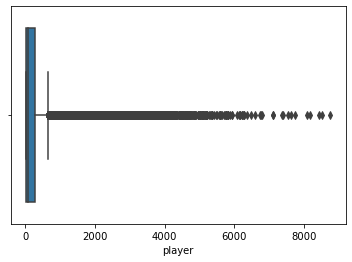

In [41]:
sns.boxplot(x=player_question_cnt);

поставим отсечку в 400 вопросов, что соответствует 8-13 турнирным играм

In [42]:
reasonable_players = set(player_question_cnt[player_question_cnt >= 400].index)

In [58]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(question_answer_data.loc[
    question_answer_data['player'].isin(reasonable_players), 
    ["player", "question"]])

train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(question_answer_data.loc[
    question_answer_data['player'].isin(reasonable_players), 
    "initial_label"].values).view(-1, 1)

model = LogisticRegression(x.shape[1])

можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;

In [59]:
del train_data

Просто так выбросить игроков не получится из-за нашей ЕМ схемы - будет сильно повышена вероятность игроков в команде с "ноунеймами" взять вопрос.

Вместо этого будем считать вероятность взять вопрос игроком без рейтинга = 0.5

Тренироваться будем только на игроках с достаточным рейтингом, но учитывая игроков без рейтинга в знаменателе на Е-шаге

In [60]:
def e_step(data, predicts, reasonable_players):
    player_idx = data["player"].isin(reasonable_players)
    data.loc[player_idx, "label"] = predicts
    data.loc[~player_idx, "label"] = 0.5
    data.loc[data["initial_label"] == 0, "label"] = 0
    idx = data["initial_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question"])["label"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp  
    new_label = data.loc[player_idx, "label"].values
    return torch.FloatTensor(new_label).view(-1, 1)

In [61]:
for i in range(10):
    m_step(model, x, y, lr=1, n_iter=100)
    predicts = model(x).detach().numpy().ravel()
    y = e_step(question_answer_data, predicts, reasonable_players)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    print(f"Iter: {i}")
    calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

Iter: 0
spearman: 0.6186767832955465
kendl: 0.4801412112202675
Iter: 1
spearman: 0.6309325248850433
kendl: 0.4919240229607929
Iter: 2
spearman: 0.6374962052977347
kendl: 0.49806553227021433
Iter: 3
spearman: 0.6423755701411579
kendl: 0.5035767366740213
Iter: 4
spearman: 0.6465477469897499
kendl: 0.5078193343375873
Iter: 5
spearman: 0.6495402057797481
kendl: 0.5101259248680485
Iter: 6
spearman: 0.6510834721099233
kendl: 0.5109031766535893
Iter: 7
spearman: 0.654703261114488
kendl: 0.5137966175673448
Iter: 8
spearman: 0.6583329095061677
kendl: 0.5164653624370664
Iter: 9
spearman: 0.6587816856759683
kendl: 0.5170655577602744


In [66]:
parameters = model.fc.weight.data[0].numpy()

In [72]:
top_20_players = get_top_players(parameters, 20)

как мы видим в топе оказались игроки с высоким рейтингом, однако корелляция сильно упала. Из-за неучета множества игроков мы не можем прогнозировать их силу.

но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;

In [92]:
for i, name in enumerate(top_20_players):
    print(f"{i + 1} {name}")

1 Царёв Михаил Сергеевич 34328
2 Руссо Максим Михайлович 27403
3 Мереминский Станислав Григорьевич 20691
4 Мокин Игорь Викторович 74001
5 Коробейников Александр Геннадьевич 15727
6 Брутер Александра Владимировна 4270
7 Семушин Иван Николаевич 28751
8 Гилёв Алексей Владимирович 7008
9 Мосягин Александр Владимирович 21698
10 Савченков Михаил Владимирович 27822
11 Сорожкин Артём Сергеевич 30152
12 Дёмин Евгений Васильевич 9061
13 Марков Александр Валерьевич 19915
14 Новиков Илья Сергеевич 22935
15 Николенко Сергей Игоревич 22799
16 Бровер Сусанна Марковна 4226
17 Либер Александр Витальевич 18332
18 Мерзляков Максим Петрович 20700
19 Дубинская Ольга Игоревна 9834
20 Моносов Борис Яковлевич 21487


предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).


давайте добавим веса к нашей функции потерь

веса будут зависить от количества сыгранных вопросов игроком

$$\large{weight = \frac{q_{player} + \alpha}{q_{total} + \alpha p_{total}}}$$

Где:

- $q_{player}$ - количество вопросов сыгранных игроком
- $q_{total}$ - общее количество вопросов
- $p_{total}$ - общее количество игроков
- $\alpha$ - сглаживающая константа, необходима для того чтобы игроки которые сыграли слишком мало игр не получали слишком большую регуляризацию

In [116]:
alpha = 1
question_reg = (
    (question_answer_data.groupby("player")["question"].transform("nunique") + alpha) / 
    (question_answer_data["question"].nunique() + alpha * question_answer_data["player"].nunique())
)

In [117]:
encoder = OneHotEncoder()

train_data = encoder.fit_transform(question_answer_data[["player", "question"]])

train_data = train_data.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((train_data.row, train_data.col))),
    torch.FloatTensor(train_data.data)
)

y = torch.FloatTensor(question_answer_data["initial_label"].values).view(-1, 1)

question_reg = torch.FloatTensor(question_reg).view(-1, 1)

model = LogisticRegression(x.shape[1])

In [118]:
def m_step(model, x, y, q_const, lr=1e-4, reg_alpha=0.1, n_iter=50):
    
    model.fc.reset_parameters()
    criteria = nn.BCELoss(reduction="none")
    optimizer = optim.Adam(model.parameters(), lr)
    for i in range(n_iter):

        optimizer.zero_grad()
        output = model(x)
        loss = criteria(output, y) * reg_alpha * q_const
        loss = loss.sum()
        loss.backward()
        optimizer.step()

In [119]:
def e_step(data, predicts):
    data["label"] = predicts
    data.loc[data["initial_label"] == 0, "label"] = 0
    idx = data["initial_label"] == 1
    sp = data.loc[idx].groupby(["team_id", "question"])["label"].transform(lambda x: 1 - np.prod(1 - x.values))
    data.loc[idx, "label"] = data.loc[idx, "label"] / sp
    new_label = data["label"].values
    return torch.FloatTensor(new_label).view(-1, 1)

In [120]:
for i in range(10):
    m_step(model, x, y, question_reg, reg_alpha=1, lr=1, n_iter=100)
    predicts = model(x).detach().numpy().ravel()
    y = e_step(question_answer_data, predicts)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predicts = model(x).detach().numpy().ravel()
    print(f"Iter: {i}")
    calc_metrics(test_data, encoder, model.fc.weight.data[0].numpy(), model.fc.bias.data[0].numpy())

Iter: 0
spearman: 0.7874710928349219
kendl: 0.630746226803847
Iter: 1
spearman: 0.7967773338766985
kendl: 0.6417672928582311
Iter: 2
spearman: 0.7982627692103514
kendl: 0.6431054510061723
Iter: 3
spearman: 0.8006221750170823
kendl: 0.6458062606792885
Iter: 4
spearman: 0.8003250293053794
kendl: 0.6447465399449644
Iter: 5
spearman: 0.8018255870428111
kendl: 0.6468591503510176
Iter: 6
spearman: 0.8023051613330486
kendl: 0.6470983844560139
Iter: 7
spearman: 0.8058750549287725
kendl: 0.6514019743604386
Iter: 8
spearman: 0.8068277191754477
kendl: 0.6521924637511632
Iter: 9
spearman: 0.8073125348071527
kendl: 0.6524234884217239


In [121]:
parameters = model.fc.weight.data[0].numpy()
top_20_players = get_top_players(parameters, 20)

for i, name in enumerate(top_20_players):
    print(f"{i + 1} {name}")

1 Пилипенко Максим Игоревич 38175
2 Немец Илья Сергеевич 22474
3 Козлова Ольга Александровна 14996
4 Королихин Анатолий  199115
5 Луконин Дмитрий  199114
6 Петров Роман  199111
7 Петров Игорь  199112
8 Иоаннидис Андриан  199113
9 Бровченко Елена Борисовна 199963
10 Подюкова Валентина  202410
11 Голудина Мария Юрьевна 188876
12 Фрайман Феликс  33459
13 Лазарева Галина Вячеславовна 17750
14 Кудинов Дмитрий Сергеевич 40411
15 Фёдоров Дамир  199118
16 Усов Александр  199117
17 Чернецкий Евгений  199116
18 Марков Василий  199119
19 Спектор Евгений Павлович 30260
20 Буйная Александра Петровна 136300


In [122]:
top_20_players_id = [int(v.split(" ")[-1]) for v in top_20_players]

In [123]:
player_tournament_cnt[player_tournament_cnt["player"].isin(top_20_players_id)]

,player,tournament_count,player_name
2114,14996,1,Козлова Ольга Александровна
2520,17750,1,Лазарева Галина Вячеславовна
3183,22474,2,Немец Илья Сергеевич
4254,30260,8,Спектор Евгений Павлович
4689,33459,1,Фрайман Феликс
5360,38175,1,Пилипенко Максим Игоревич
5560,40411,1,Кудинов Дмитрий Сергеевич
15716,136300,1,Буйная Александра Петровна
29747,188876,1,Голудина Мария Юрьевна
39093,199111,1,Петров Роман
